In [10]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

In [21]:
class Inventory_management(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(Inventory_management, self).__init__()
        self.max_order = 10
        self.action_space = spaces.Discrete(self.max_order + 1)
        self.observation_space = spaces.Box(low=0, high=100, shape=(3,), dtype=np.int32)
        self.full_price = 10.0
        self.discount_price = 5.0
        self.order_cost = 7.0
        self.waste_penalty = 3.0
        self.demand_lambda = 5
        self.max_days = 100
        self.reset()

    def reset(self, **kwargs):
        self.inventory = np.array([0, 0, 0], dtype=np.int32)
        self.day = 0
        return self._get_obs(), {}

    def _get_obs(self):
        return self.inventory.astype(np.float32)

    def step(self, action):
        terminated = False
        truncated = False
        info = {}
        reward = 0.0
        expired = self.inventory[2]
        reward -= self.waste_penalty * expired
        self.inventory[2] = self.inventory[1]
        self.inventory[1] = self.inventory[0]
        new_order = int(action)
        self.inventory[0] = new_order
        reward -= self.order_cost * new_order
        demand = np.random.poisson(self.demand_lambda)
        sales = 0
        revenue = 0.0
        remaining_demand = demand
        sell_from_I1 = min(self.inventory[2], remaining_demand)
        revenue += sell_from_I1 * self.discount_price
        self.inventory[2] -= sell_from_I1
        remaining_demand -= sell_from_I1
        sales += sell_from_I1
        sell_from_I2 = min(self.inventory[1], remaining_demand)
        revenue += sell_from_I2 * self.full_price
        self.inventory[1] -= sell_from_I2
        remaining_demand -= sell_from_I2
        sales += sell_from_I2
        sell_from_I3 = min(self.inventory[0], remaining_demand)
        revenue += sell_from_I3 * self.full_price
        self.inventory[0] -= sell_from_I3
        remaining_demand -= sell_from_I3
        sales += sell_from_I3
        reward += revenue
        self.day += 1
        if self.day >= self.max_days:
            terminated = True
        obs = self._get_obs()
        return obs, reward, terminated, truncated, info

    def render(self, mode='human'):
        print(f"Day: {self.day}, Inventory: {self.inventory}")

In [22]:
class DQN(nn.Module):
    def __init__(self, state_dimension, action_dimension):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dimension, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dimension)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class Replay_memory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [23]:
def train_function(env, number_episodes=500, batch_size=32, gamma=0.99,
              epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,
              target_update=10, memory_capacity=10000, learning_rate=1e-3):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    state_dimension = env.observation_space.shape[0]
    action_dimension = env.action_space.n
    policy_network = DQN(state_dimension, action_dimension).to(device)
    target_net = DQN(state_dimension, action_dimension).to(device)
    target_net.load_state_dict(policy_network.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_network.parameters(), lr=learning_rate)
    memory = Replay_memory(memory_capacity)
    episode_rewards = []
    epsilon_decay_history = []
    epsilon = epsilon_start

    for episode in range(number_episodes):
        state, _ = env.reset()
        total_rewards = 0
        terminated = False

        while not terminated:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

                with torch.no_grad():
                    q_values = policy_network(state_tensor)
                action = int(torch.argmax(q_values, dim=1).item())

            next_state, reward, terminated, truncated, _ = env.step(action)
            total_rewards += reward
            memory.push(state, action, reward, next_state, terminated)
            state = next_state
            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)
                batch_state = torch.FloatTensor(batch_state).to(device)
                batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
                batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
                batch_next_state = torch.FloatTensor(batch_next_state).to(device)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)
                current_q = policy_network(batch_state).gather(1, batch_action)

                with torch.no_grad():
                    max_next_q = target_net(batch_next_state).max(1)[0].unsqueeze(1)
                target_q = batch_reward + gamma * max_next_q * (1 - batch_done)
                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        epsilon_decay_history.append(epsilon)
        episode_rewards.append(total_rewards)
        if episode % target_update == 0:
            target_net.load_state_dict(policy_network.state_dict())

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}/{number_episodes}, Total Reward: {total_rewards:.2f}, Epsilon: {epsilon:.3f}")

    return episode_rewards, epsilon_decay_history, policy_network, device


In [24]:
env = Inventory_management()
number_episodes = 300
training_rewards, epsilon_decay_history, trained_policy, device = train_function(env, number_episodes=number_episodes)

Using device: cuda
Episode 10/300, Total Reward: 393.00, Epsilon: 0.951
Episode 20/300, Total Reward: 84.00, Epsilon: 0.905
Episode 30/300, Total Reward: 599.00, Epsilon: 0.860
Episode 40/300, Total Reward: 416.00, Epsilon: 0.818
Episode 50/300, Total Reward: 486.00, Epsilon: 0.778
Episode 60/300, Total Reward: 599.00, Epsilon: 0.740
Episode 70/300, Total Reward: 798.00, Epsilon: 0.704
Episode 80/300, Total Reward: 569.00, Epsilon: 0.670
Episode 90/300, Total Reward: 817.00, Epsilon: 0.637
Episode 100/300, Total Reward: 692.00, Epsilon: 0.606
Episode 110/300, Total Reward: 911.00, Epsilon: 0.576
Episode 120/300, Total Reward: 796.00, Epsilon: 0.548
Episode 130/300, Total Reward: 941.00, Epsilon: 0.521
Episode 140/300, Total Reward: 907.00, Epsilon: 0.496
Episode 150/300, Total Reward: 794.00, Epsilon: 0.471
Episode 160/300, Total Reward: 1072.00, Epsilon: 0.448
Episode 170/300, Total Reward: 1222.00, Epsilon: 0.427
Episode 180/300, Total Reward: 806.00, Epsilon: 0.406
Episode 190/300, 

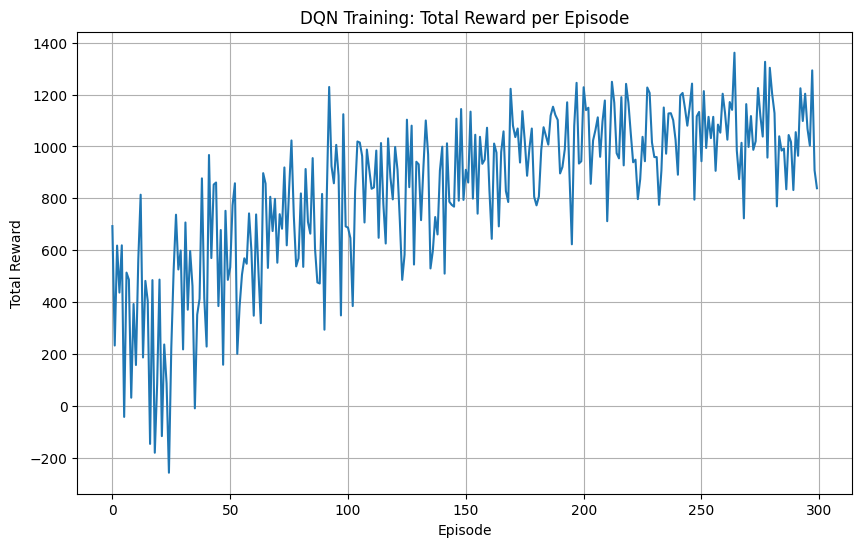

In [25]:
plt.figure(figsize=(10,6))
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training: Total Reward per Episode")
plt.grid(True)
plt.show()

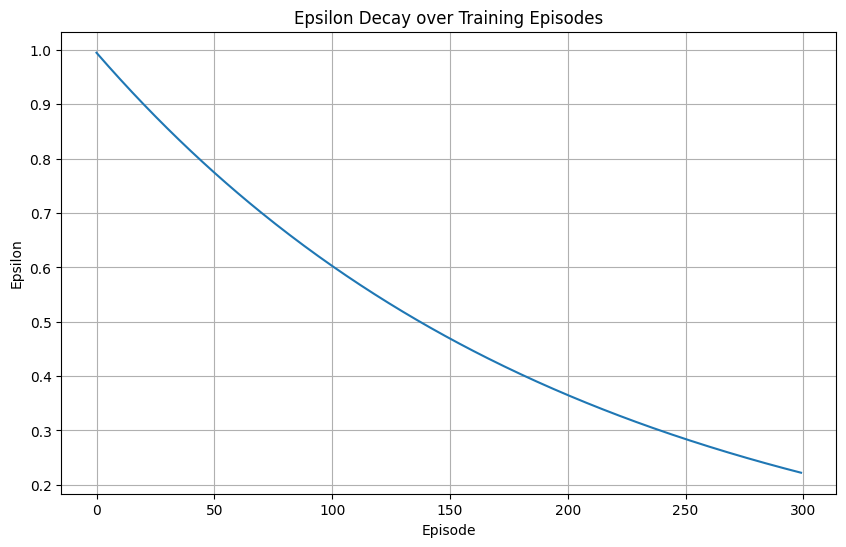

In [26]:
plt.figure(figsize=(10,6))
plt.plot(epsilon_decay_history)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay over Training Episodes")
plt.grid(True)
plt.show()

In [27]:
number_test_episodes = 50
testing_rewards = []

for ep in range(number_test_episodes):
    state, _ = env.reset()
    total_rewards = 0
    terminated = False

    while not terminated:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = trained_policy(state_tensor)
        action = int(torch.argmax(q_values, dim=1).item())
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_rewards += reward
        state = next_state

    testing_rewards.append(total_rewards)
    print(f"Test Episode {ep+1}/{number_test_episodes}, Total Reward: {total_rewards:.2f}")

Test Episode 1/50, Total Reward: 1236.00
Test Episode 2/50, Total Reward: 1029.00
Test Episode 3/50, Total Reward: 1245.00
Test Episode 4/50, Total Reward: 1205.00
Test Episode 5/50, Total Reward: 1208.00
Test Episode 6/50, Total Reward: 1077.00
Test Episode 7/50, Total Reward: 1241.00
Test Episode 8/50, Total Reward: 1297.00
Test Episode 9/50, Total Reward: 1074.00
Test Episode 10/50, Total Reward: 1003.00
Test Episode 11/50, Total Reward: 1134.00
Test Episode 12/50, Total Reward: 1036.00
Test Episode 13/50, Total Reward: 1153.00
Test Episode 14/50, Total Reward: 1238.00
Test Episode 15/50, Total Reward: 1182.00
Test Episode 16/50, Total Reward: 1153.00
Test Episode 17/50, Total Reward: 1243.00
Test Episode 18/50, Total Reward: 1330.00
Test Episode 19/50, Total Reward: 1070.00
Test Episode 20/50, Total Reward: 1171.00
Test Episode 21/50, Total Reward: 1324.00
Test Episode 22/50, Total Reward: 1129.00
Test Episode 23/50, Total Reward: 1487.00
Test Episode 24/50, Total Reward: 1243.00
T

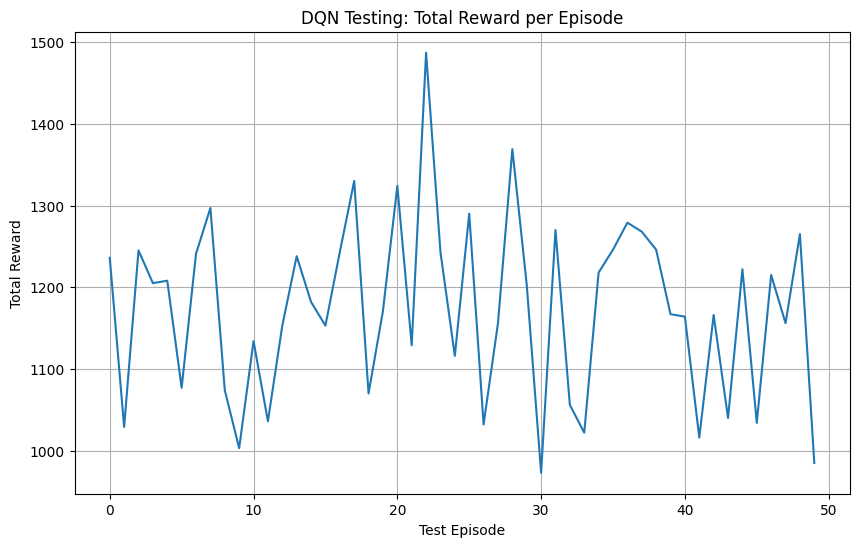

In [28]:
plt.figure(figsize=(10,6))
plt.plot(testing_rewards)
plt.xlabel("Test Episode")
plt.ylabel("Total Reward")
plt.title("DQN Testing: Total Reward per Episode")
plt.grid(True)
plt.show()